<a href="https://colab.research.google.com/github/RitwijParmar/master/blob/main/.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
from sklearn.metrics import confusion_matrix, classification_report

# Seaborn style
sns.set_style("whitegrid")

In [65]:
# Fetching
datasetId = "3tj7-3tdz"
recordsToGet = 30000
apiUrl = f"https://data.buffalony.gov/resource/{datasetId}.json"

print(f"Fetching {recordsToGet} records...")
response = requests.get(apiUrl, params={"$limit": recordsToGet})

if response.status_code == 200:
    allRecords = response.json()
    rawdf = pd.DataFrame(allRecords)
    print(f"Success! Table has {len(rawdf)} records.")
else:
    print(f"Server error {response.status_code}.")
    rawdf = pd.DataFrame() # Empty

Fetching 30000 records...
Success! Table has 30000 records.


In [66]:
# Inspect
print("Dataset Shape:", rawdf.shape)
print("\nDataset Info:")
rawdf.info()

# Create a copy for processing
df = rawdf.copy()

Dataset Shape: (30000, 34)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   createddate                  30000 non-null  object
 1   casenumber                   30000 non-null  object
 2   department                   29999 non-null  object
 3   type                         30000 non-null  object
 4   status                       30000 non-null  object
 5   statusdescription            26263 non-null  object
 6   closeddate                   28679 non-null  object
 7   propertyid                   29121 non-null  object
 8   reportedlocation             29202 non-null  object
 9   assessednumber               29472 non-null  object
 10  assessedstreet               29818 non-null  object
 11  street                       29879 non-null  object
 12  secondarystreet              2377 non-null   o

In [67]:
# Handle missing values
print("Missing values before cleaning (Top 5):")
print(df.isnull().sum().sort_values(ascending=False).head())

# Drop column with excessive missing values
if 'secondarystreet' in df.columns:
    df.drop(columns=['secondarystreet'], inplace=True)
    print("\nDropped 'secondarystreet' column.")

# Fill categorical NaNs with a placeholder or mode
df['division'] = df['division'].fillna('Unknown')
df['zip'] = df['zip'].fillna(df['zip'].mode()[0])

# Fill numerical NaNs with the median
for col in ['latitude', 'longitude']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Ensure numeric
        df[col] = df[col].fillna(df[col].median())

Missing values before cleaning (Top 5):
secondarystreet                27623
division                       10309
:@computed_region_nmyf_6jtp     3795
:@computed_region_yg52_574g     3789
:@computed_region_h7a8_iwt4     3786
dtype: int64

Dropped 'secondarystreet' column.


In [68]:
# Fill remaining object columns
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        df[col].fillna('Not Provided', inplace=True)

print("\nFinal check for missing values:")
print(f"Total missing values remaining: {df.isnull().sum().sum()}")

<ipython-input-68-a104c0df318b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Not Provided', inplace=True)



Final check for missing values:
Total missing values remaining: 0


In [69]:
# Format strings
stringCols = df.select_dtypes(include='object').columns

for col in stringCols:
    df[col] = df[col].str.lower().str.strip()

# Specific fix for city name
df['city'] = df['city'].str.replace('buffalo ny', 'buffalo', regex=False)

print("String formatting complete.")
print("Unique cities after cleaning:", df['city'].unique())

String formatting complete.
Unique cities after cleaning: ['buffalo' 'not provided' 'amherst' 'cheektowaga' 'tonawanda']


In [70]:
# Handle outliers
for col in ['latitude', 'longitude']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR

    # Cap outliers
    df[col] = np.where(df[col] < lowerBound, lowerBound, df[col])
    df[col] = np.where(df[col] > upperBound, upperBound, df[col])

print("Outliers capped for latitude and longitude.")
print(df[['latitude', 'longitude']].describe())

Outliers capped for latitude and longitude.
           latitude     longitude
count  30000.000000  30000.000000
mean      42.894499    -78.830846
std        0.051170      0.050066
min       42.782087    -78.909858
25%       42.871928    -78.869544
50%       42.908794    -78.834735
75%       42.931822    -78.810255
max       42.965217    -78.721322


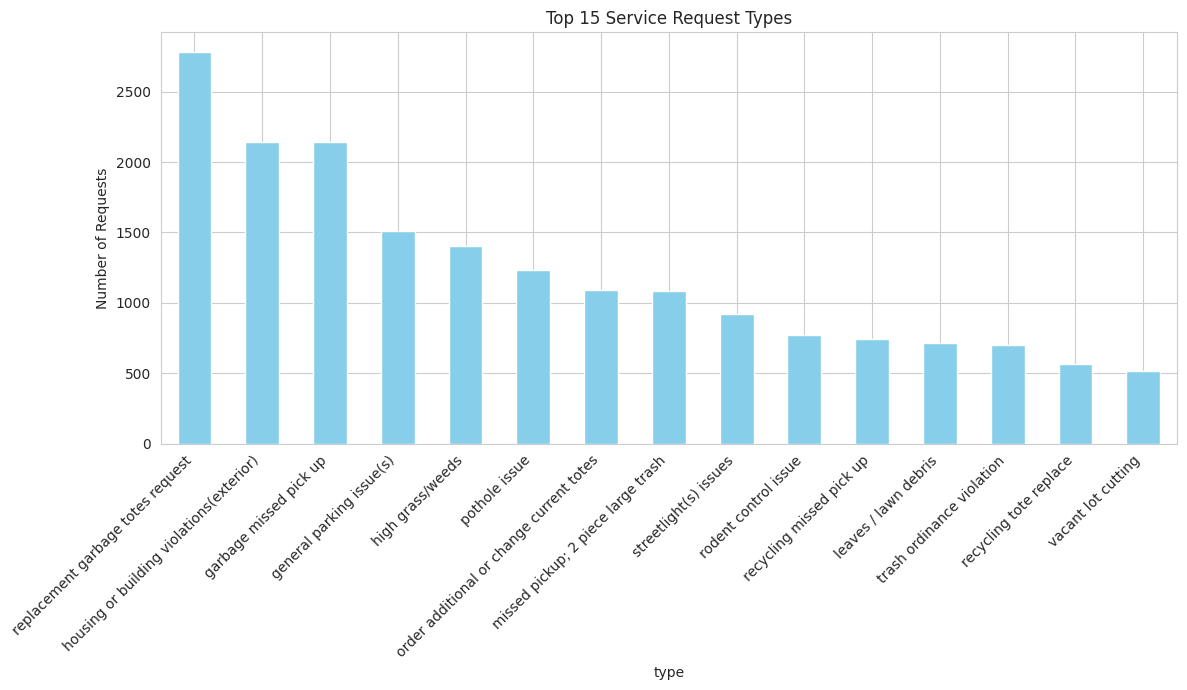

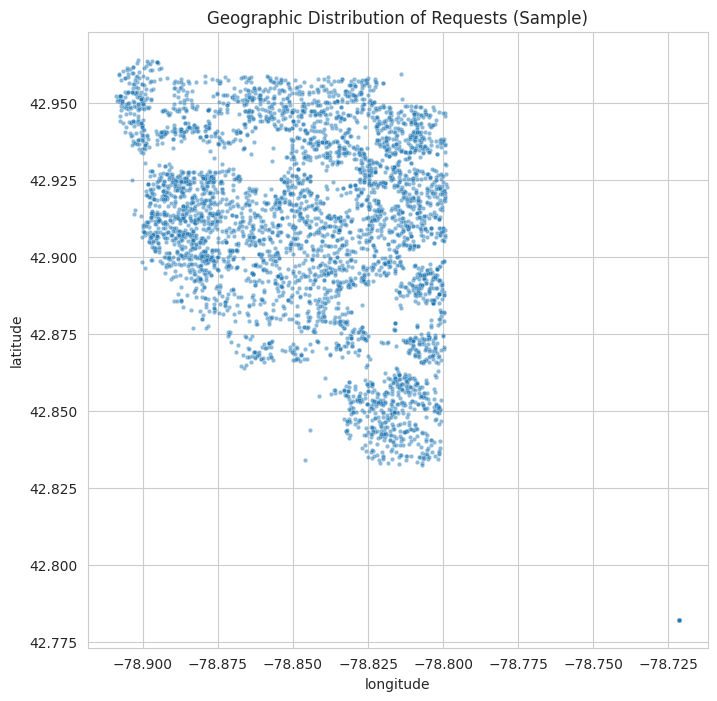

<ipython-input-71-20afd5903eb6>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='status', data=df, order=df['status'].value_counts().index, palette='viridis')


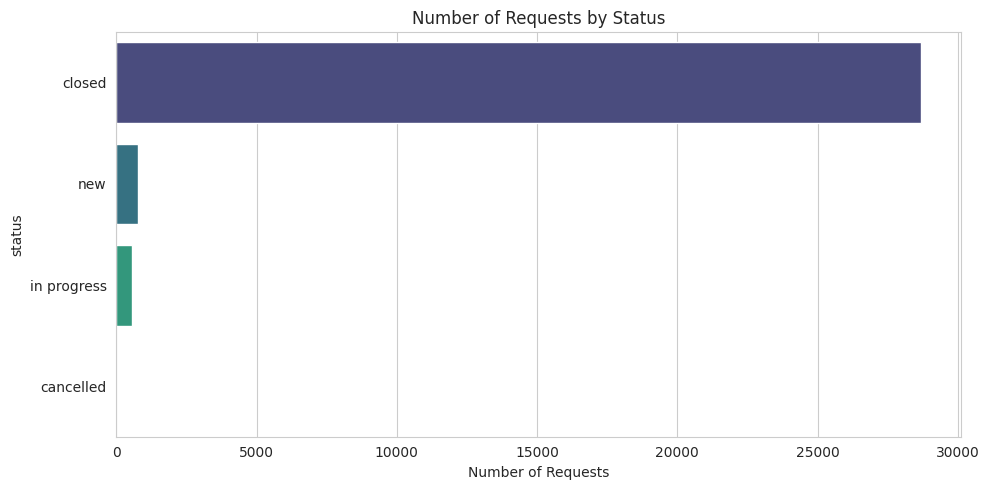

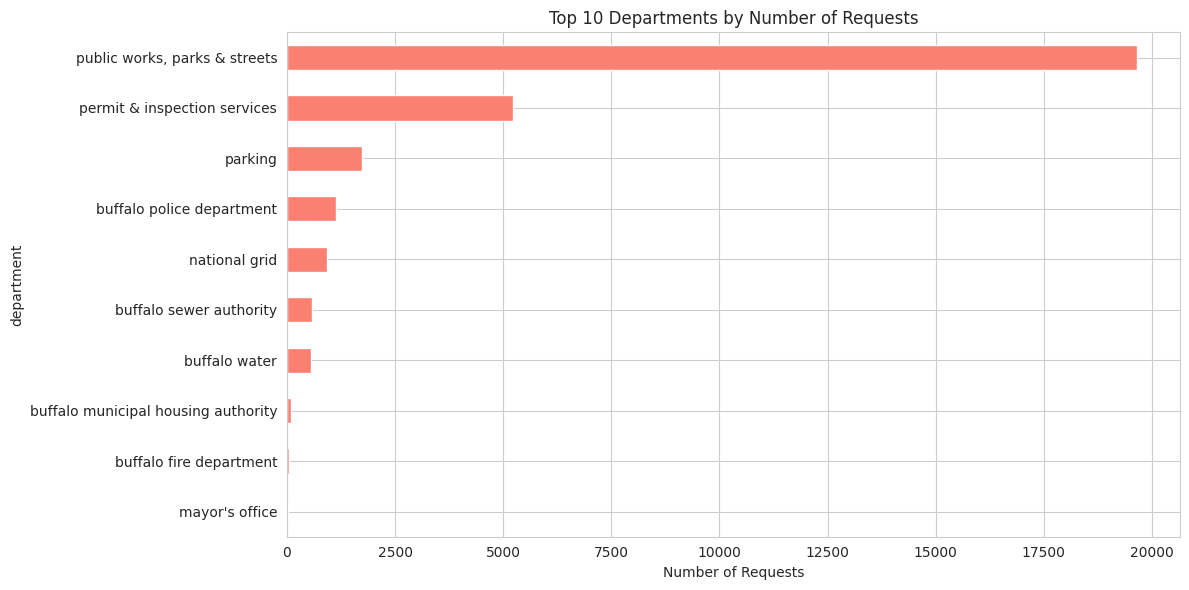

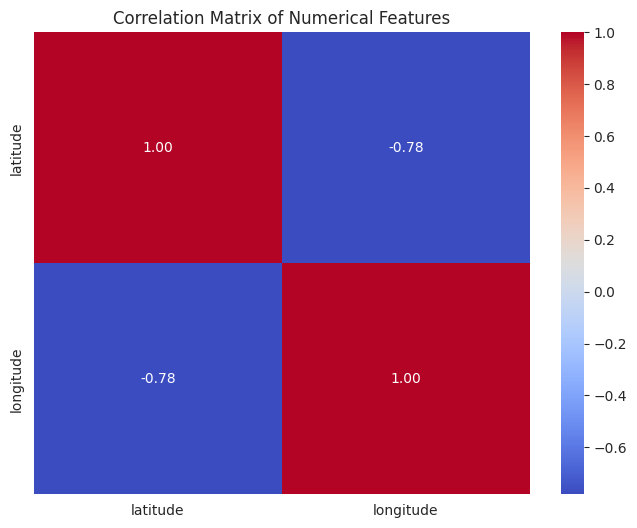

In [71]:
# Plot 1: Top 15 Service Request Types
plt.figure(figsize=(12, 7))
df['type'].value_counts().nlargest(15).plot(kind='bar', color='skyblue')
plt.title('Top 15 Service Request Types')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot 2: Geographic Distribution
plt.figure(figsize=(8, 8))
sns.scatterplot(x='longitude', y='latitude', data=df.sample(5000), s=10, alpha=0.5)
plt.title('Geographic Distribution of Requests (Sample)')
plt.show()

# Plot 3: Requests by Status
plt.figure(figsize=(10, 5))
sns.countplot(y='status', data=df, order=df['status'].value_counts().index, palette='viridis')
plt.title('Number of Requests by Status')
plt.xlabel('Number of Requests')
plt.tight_layout()
plt.show()

# Plot 4: Top 10 Departments by Request Count
plt.figure(figsize=(12, 6))
df['department'].value_counts().nlargest(10).plot(kind='barh', color='salmon')
plt.title('Top 10 Departments by Number of Requests')
plt.xlabel('Number of Requests')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot 5: Correlation Matrix of Numerical Features
plt.figure(figsize=(8, 6))
numericalDF = df.select_dtypes(include=np.number)
correlation_matrix = numericalDF.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [72]:
# Target (Y)
targetColumn = 'department'
# Using the original dataframe to avoid one-hot encoded columns
y = rawdf[targetColumn].fillna('Unknown').astype(str).str.lower().str.strip()

# Label encode the target
labelEncoder = LabelEncoder()
yencoded = labelEncoder.fit_transform(y)

# Features (X)
# Drop identifiers, dates, free text, and the original target column
dropCols = [
    'casenumber', 'propertyid', 'createddate', 'closeddate', 'reportedlocation',
    'assessednumber', 'assessedstreet', 'street', 'location', 'department'
]
X = df.drop(columns=dropCols, errors='ignore')

print("Target (y) shape:", yencoded.shape)
print("Features (X) shape before encoding:", X.shape)

Target (y) shape: (30000,)
Features (X) shape before encoding: (30000, 23)


In [73]:
# One-hot encode
# Select columns with a manageable number of unique values
categoricalCols = [col for col in X.select_dtypes(include='object').columns if X[col].nunique() < 50]
X = pd.get_dummies(X, columns=categoricalCols, dtype=int)

print("Features (X) shape after encoding:", X.shape)

Features (X) shape after encoding: (30000, 207)


In [74]:
# Ensure all columns are numeric
X = X.select_dtypes(include=np.number)

# Normalize
for col in ['latitude', 'longitude']:
    if col in X.columns:
        minVal = X[col].min()
        maxVal = X[col].max()
        if maxVal - minVal > 0:
            X[col] = (X[col] - minVal) / (maxVal - minVal)

print("Final features (X) shape:", X.shape)
print(X[['latitude', 'longitude']].describe())

Final features (X) shape: (30000, 201)
           latitude     longitude
count  30000.000000  30000.000000
mean       0.613836      0.419082
std        0.279416      0.265549
min        0.000000      0.000000
25%        0.490588      0.213829
50%        0.691896      0.398455
75%        0.817646      0.528297
max        1.000000      1.000000


In [75]:



# Ratios
testSize = 0.15
validationSize = 0.15 / (1 - testSize)

# Splitting into training and test sets
xtemp, xtest, ytemp, ytest = train_test_split(
    X.values, yencoded, test_size=testSize, random_state=42
)

# Splitting into final training and validation sets
xtrain, xval, ytrain, yval = train_test_split(
    xtemp, ytemp, test_size=validationSize, random_state=42
)

# Printing shapes
print("Training set shape:", xtrain.shape, ytrain.shape)
print("Validation set shape:", xval.shape, yval.shape)
print("Test set shape:", xtest.shape, ytest.shape)

Training set shape: (21000, 201) (21000,)
Validation set shape: (4500, 201) (4500,)
Test set shape: (4500, 201) (4500,)


In [76]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create Tensors
trainTensors = TensorDataset(torch.tensor(xtrain, dtype=torch.float32), torch.tensor(ytrain, dtype=torch.long))
valTensors = TensorDataset(torch.tensor(xval, dtype=torch.float32), torch.tensor(yval, dtype=torch.long))
testTensors = TensorDataset(torch.tensor(xtest, dtype=torch.float32), torch.tensor(ytest, dtype=torch.long))

# Create DataLoaders
batchSize = 64
trainLoader = DataLoader(trainTensors, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(valTensors, batch_size=batchSize, shuffle=False)
testLoader = DataLoader(testTensors, batch_size=batchSize, shuffle=False)

Using device: cpu


In [78]:
# Defining network
class Net(nn.Module):
    def __init__(self, inputDim, outputDim):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(inputDim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, outputDim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.output(x)
        return x

# Instantiating
inputDim = xtrain.shape[1]
outputDim = len(labelEncoder.classes_)
model = Net(inputDim, outputDim).to(device)
print(model)

Net(
  (layer1): Linear(in_features=201, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=14, bias=True)
  (activation): ReLU()
)


In [79]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25

bestAccuracy = 0.0
bestModel = None
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

startTime = time.time()

for epoch in range(epochs):
    model.train()
    trainLoss, trainCorrect, trainTotal = 0, 0, 0
    for features, labels in trainLoader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        trainTotal += labels.size(0)
        trainCorrect += (predicted == labels).sum().item()

    model.eval()
    valLoss, valCorrect, valTotal = 0, 0, 0
    with torch.no_grad():
        for features, labels in valLoader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            valLoss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valTotal += labels.size(0)
            valCorrect += (predicted == labels).sum().item()

    # Record history
    trainAcc = trainCorrect / trainTotal
    valAcc = valCorrect / valTotal
    history['train_loss'].append(trainLoss / len(trainLoader))
    history['train_acc'].append(trainAcc)
    history['val_loss'].append(valLoss / len(valLoader))
    history['val_acc'].append(valAcc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {history['train_loss'][-1]:.3f} | Val Acc: {valAcc:.3f}")

    if valAcc > bestAccuracy:
        bestAccuracy = valAcc
        bestModel = model.state_dict().copy()

trainingTime = time.time() - startTime
print(f"\nTraining complete in {trainingTime:.2f}s")
print(f"Best Validation Accuracy: {bestAccuracy:.4f}")

Epoch 1/25 | Train Loss: 0.782 | Val Acc: 0.824
Epoch 2/25 | Train Loss: 0.485 | Val Acc: 0.828
Epoch 3/25 | Train Loss: 0.475 | Val Acc: 0.831
Epoch 4/25 | Train Loss: 0.469 | Val Acc: 0.833
Epoch 5/25 | Train Loss: 0.464 | Val Acc: 0.835
Epoch 6/25 | Train Loss: 0.462 | Val Acc: 0.835
Epoch 7/25 | Train Loss: 0.455 | Val Acc: 0.831
Epoch 8/25 | Train Loss: 0.455 | Val Acc: 0.835
Epoch 9/25 | Train Loss: 0.454 | Val Acc: 0.834
Epoch 10/25 | Train Loss: 0.447 | Val Acc: 0.838
Epoch 11/25 | Train Loss: 0.445 | Val Acc: 0.839
Epoch 12/25 | Train Loss: 0.443 | Val Acc: 0.839
Epoch 13/25 | Train Loss: 0.441 | Val Acc: 0.838
Epoch 14/25 | Train Loss: 0.440 | Val Acc: 0.840
Epoch 15/25 | Train Loss: 0.435 | Val Acc: 0.834
Epoch 16/25 | Train Loss: 0.433 | Val Acc: 0.840
Epoch 17/25 | Train Loss: 0.432 | Val Acc: 0.836
Epoch 18/25 | Train Loss: 0.429 | Val Acc: 0.836
Epoch 19/25 | Train Loss: 0.429 | Val Acc: 0.838
Epoch 20/25 | Train Loss: 0.427 | Val Acc: 0.840
Epoch 21/25 | Train Loss: 0.4

Best model saved to best_model.pt


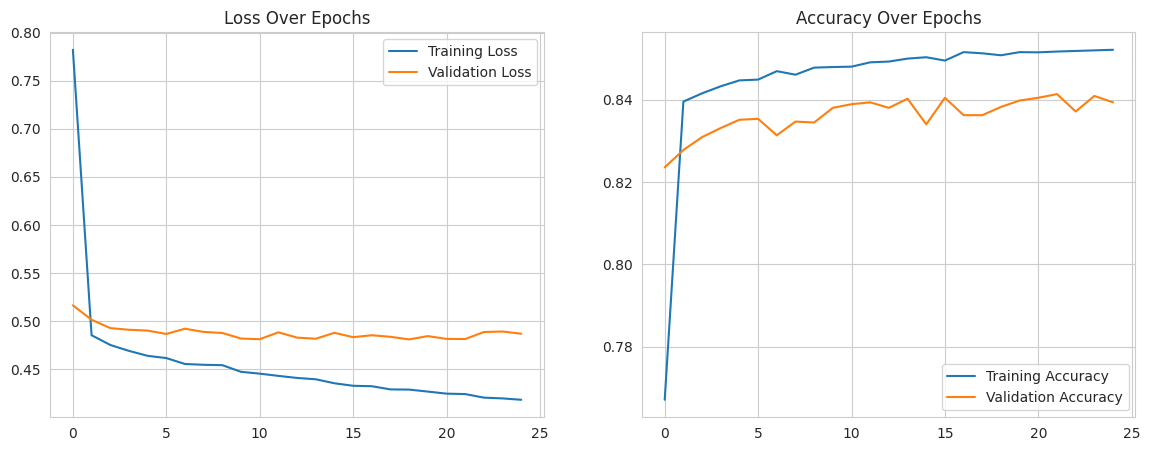

In [80]:
# Save model
torch.save(bestModel, 'best_model.pt')
print("Best model saved to best_model.pt")

# Plotting
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [81]:
# Load best model
model.load_state_dict(bestModel)
model.eval()

testCorrect, testTotal = 0, 0
allPredictions = []
allLabels = []

with torch.no_grad():
    for features, labels in testLoader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        testTotal += labels.size(0)
        testCorrect += (predicted == labels).sum().item()
        allPredictions.extend(predicted.cpu().numpy())
        allLabels.extend(labels.cpu().numpy())

testAccuracy = testCorrect / testTotal
testLoss = criterion(outputs, labels).item()

print(f"Final Test Loss: {testLoss:.4f}")
print(f"Final Test Accuracy: {testAccuracy:.4f} ({testAccuracy*100:.2f}%)")

if testAccuracy > 0.75:
    print("\nAccuracy is above 75%! Which is above the reqirement.")
else:
    print("\nAccuracy is below 75%. Consider tuning hyperparameters.")

Final Test Loss: 0.4273
Final Test Accuracy: 0.8396 (83.96%)

Accuracy is above 75%! Which is above the reqirement.


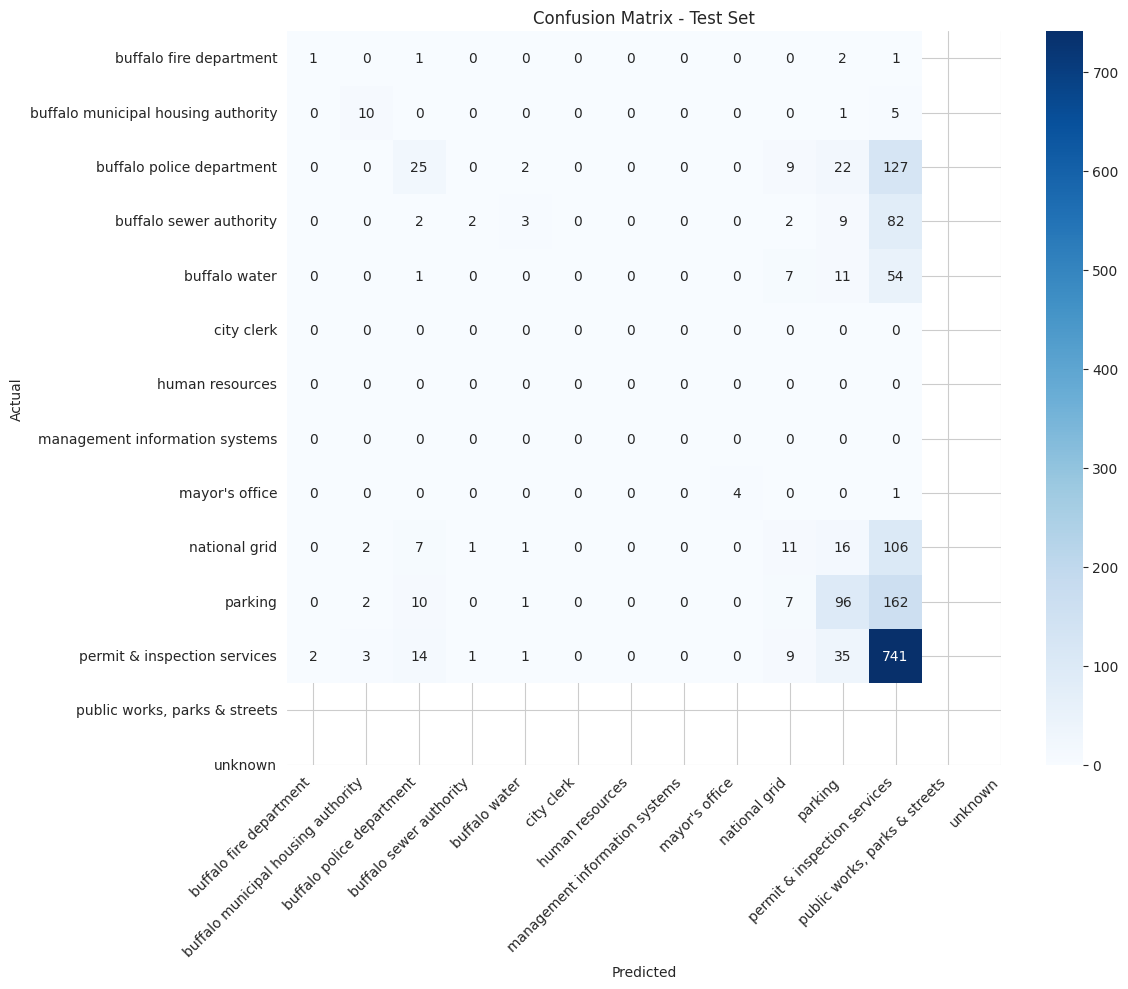


--- Classification Report ---
                                     precision    recall  f1-score   support

            buffalo fire department       0.33      0.20      0.25         5
buffalo municipal housing authority       0.59      0.62      0.61        16
          buffalo police department       0.42      0.14      0.20       185
            buffalo sewer authority       0.50      0.02      0.04       100
                      buffalo water       0.00      0.00      0.00        73
                         city clerk       0.00      0.00      0.00         0
                    human resources       0.00      0.00      0.00         0
     management information systems       0.00      0.00      0.00         0
                     mayor's office       1.00      0.80      0.89         5
                      national grid       0.24      0.08      0.12       144
                            parking       0.50      0.35      0.41       278
       permit & inspection services       0.

In [82]:
# Confusion Matrix
cm = confusion_matrix(allLabels, allPredictions, labels=np.arange(outputSize))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labelEncoder.classes_, yticklabels=labelEncoder.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification Report
print("\n--- Classification Report ---")
# Use labels parameter to ensure all classes are shown
report = classification_report(allLabels, allPredictions,
                               labels=np.arange(outputSize),
                               target_names=labelEncoder.classes_,
                               zero_division=0)
print(report)